
# 1.  Topic

In this project we will load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data.

https://github.com/mrjaiswa/Unsupervised-Learning-BBC-Classification

Here are the steps:

   Load the movie ratings dataset.

   Preprocess the data. Tokenize that.

   Split the data

   Apply matrix factorization
   
   Train the model
   
   Predict missing ratings

   Evaluate the model: Assess the performance of the matrix factorization model by comparing the predicted ratings with the actual ratings from the test set. Common evaluation metrics for recommendation systems include mean squared error (MSE) or root mean squared error (RMSE).

   Fine-tune the model: Optionally, fine-tune the matrix factorization model by adjusting hyperparameters or trying different regularization techniques to improve the prediction accuracy.


# Limitation(s) of sklearn’s non-negative matrix factorization library.



Here  I create a training and validation set for the movie data and run the nmf models to predict the rating.

I use RMSE to evaluate each prediction. What RMSE tells us that  how far we are off.




NMF is another method used for matrix factorization. Contrary to SVD, NMF decomposes the non-negative utility matrix R into the product of matrices W and H :

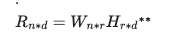


Where columns in matrix
represent components, while matrix
stores the corresponding weights. More importantly, NMF introduces constraints under which: and . The component-wise nonnegativity is a substantial difference from SVD (Gillis, 2017). Additionally to collaborative filtering, one can find use cases of NMF in clustering, image processing, or music analysis.

Firstly, it is essential to filter out movies and users with low exposure to remove some of the noise from outliers. 

There are multiple ways to skin the cat, I used just the train.csv for this purpose. I will 2 methods I learned to see if the results pan out. 

I used NMF method provided by Sci-Kit learn and the other from surprise package.

For a rank r factorisation, we have the following optimisation problem:

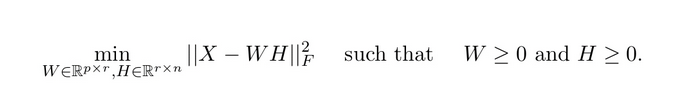

Though note that the Frobenius norm show here assumes Gaussian noise, and other norms may be used in practice depending on the distribution (e.g., Kullback-Leibler divergence for text-mining, the Itakura-Saito distance for music analysis, or the l_1 norm to improve robustness against outliers).

Another issue with NMF is that there is not guaranteed to be a single unique decomposition (in general, there might be many schemes for defining sets of basis elements).

In [6]:
from sklearn.model_selection import train_test_split


from sklearn.metrics.pairwise import cosine_similarity


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, \
KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split, cross_validate
from surprise import NMF


# (optional) Disable FutureWarning of Scikit-learn
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from surprise import NMF
import pandas_profiling as pp

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_32/2769379769.py:31: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profilin

In [2]:
movies = pd.read_csv('../input/movies/movies.csv')
train_movies = pd.read_csv('../input/movies/train.csv')
test = pd.read_csv('../input/movies/test.csv')
users = pd.read_csv('../input/movies/users.csv')


In [4]:
print(train_movies)

         uID   mID  rating
0        744  1210       5
1       3040  1584       4
2       1451  1293       5
3       5455  3176       2
4       2507  3074       5
...      ...   ...     ...
700141  1184  2916       3
700142   137  1372       5
700143   195  2514       3
700144  1676  2566       3
700145  4611  1888       1

[700146 rows x 3 columns]


Here I am using Profiler to do some EDA for me.


We find that the average document has 220 words. The maximum amount of words is 1698 and the minimum is 48.


In [7]:
profile = pp.ProfileReport(train_movies, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()
profile.to_file("first_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
print(movies.isnull().sum())
print(train_movies.isnull().sum())
print(test.isnull().sum())
print(users.isnull().sum())

mID      0
title    0
year     0
Doc      0
Com      0
Hor      0
Adv      0
Wes      0
Dra      0
Ani      0
War      0
Chi      0
Cri      0
Thr      0
Sci      0
Mys      0
Rom      0
Fil      0
Fan      0
Act      0
Mus      0
dtype: int64
uID       0
mID       0
rating    0
dtype: int64
uID       0
mID       0
rating    0
dtype: int64
uID           0
gender        0
age           0
accupation    0
zip           0
dtype: int64


/tmp/ipykernel_83/1214814393.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_movies.fillna(train_movies.median()))


<Axes: ylabel='Density'>

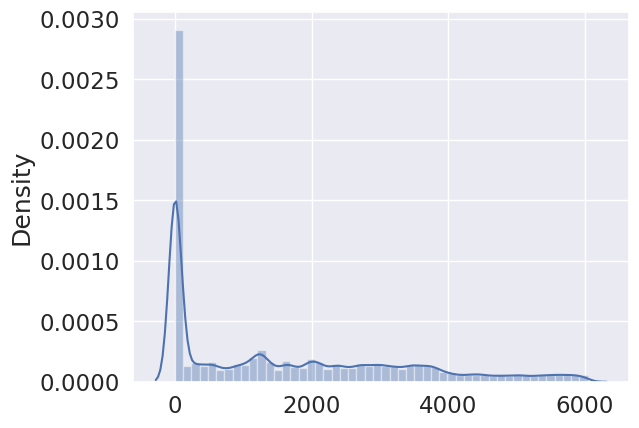

In [6]:

sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(train_movies.fillna(train_movies.median()))

Here is wordcloud 

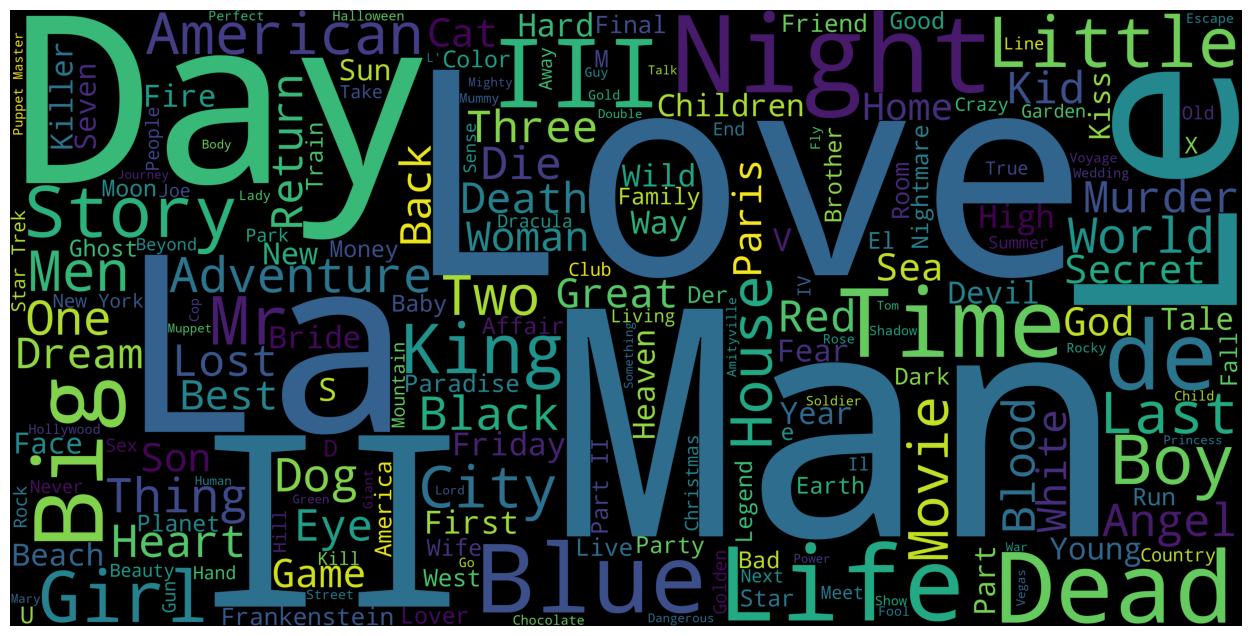

In [8]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [8]:
reader = Reader()
ratings = Dataset.load_from_df(train_movies[['uID', 'mID', 'rating']], reader)

In [9]:
train_ratings, test_ratings = train_test_split(ratings, test_size=.20, random_state = 42)
print("Size of training set: ", train_ratings.n_ratings)
print("Size of test  set: ", len(test_ratings))

Size of training set:  560116
Size of test  set:  140030


In [17]:
baseline_model = BaselineOnly(verbose = False)
baseline_model.fit(train_ratings)

In [19]:
nmf_model = NMF(random_state = 42)
nmf_model.fit(train_ratings)

In [20]:
train_predictions = nmf_model.test(train_ratings.build_testset())
test_predictions = nmf_model.test(test_ratings)

In [21]:
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.8440475391160293
RMSE on test data:  0.9248706990919365


In [22]:
benchmark = []
for algorithm in [SVD()]:
    results = cross_validate(algorithm, ratings, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp) 
    print(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

test_rmse    0.907372
fit_time      6.62637
test_time    1.884189
Algorithm         SVD
dtype: object


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.907372,6.62637,1.884189


In [ ]:
def predict(matrix):
    sortedMatrix = np.argsort(matrix)
    n_predictions, maxValue = sortedMatrix.shape
    
    predictions = [[sortedMatrix[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [ ]:
def label_permute(ytdf,yp, n=5):
    y_true = np.array(ytdf).reshape(-1)

    uniq_labels = np.unique(y_true)

    for i in range(n-1):
        perm = itertools.permutations([0,1,2,3,4])
        best_p, best_acc = None, 0
        for p in perm:
            p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
#             print(p_label_map)
            p_labels = np.array([p_label_map[label] for label in y_true])
#             print(p_labels)
            acc = accuracy_score(p_labels, yp)
            if acc > best_acc:
                best_p = {num: l for num, l in zip(p, uniq_labels)}
                best_acc = acc
    return best_p, best_acc

Here I am creating the new dataframe to train the model with a little bit of fine tuning

In [37]:
movies_nmf = pd.read_csv('../input/movies/movies.csv')
train_nmf = pd.read_csv('../input/movies/train.csv')
test_nmf = pd.read_csv('../input/movies/test.csv')
users_nmf = pd.read_csv('../input/movies/users.csv')

In [38]:
df_train = train_nmf
df_test = df_train.pop('rating')



In [39]:
df_train.shape

(700146, 2)

In [40]:
df_test.shape

(700146,)

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [43]:
X_train_movie, X_valid_movie, y_train_movie, y_valid_movie = train_test_split(df_train, df_test, test_size=0.33, random_state=42)

In [48]:
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=5, random_state=0)
clf.fit(X_train_movie, y_train_movie)
print(clf.score(X_valid_movie, y_valid_movie))

0.3510770442633381


In [41]:

print(y_train_movie.unique())

m = model("frobenius", "cd").fit(X_train_movie)
# print(f'trying with {m}')
yhat = predict(m.transform(X_valid_movie))
label_order, accuracy = label_permute(y_valid_movie, yhat)
rmse = mean_squared_error(y_valid_movie, yhat, squared=False)

print(f'RMSE {rmse}')

[1 4 3 5 2]
RMSE 3.416298543979425


In [43]:
print("="*20, "Classification Report", "="*20)
print(classification_report(y_valid_movie,yhat))

==================== Classification Report ====================
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.06      0.43      0.11     13092
           2       0.00      0.00      0.00     24786
           3       0.00      0.00      0.00     60235
           4       0.00      0.00      0.00     80657
           5       0.00      0.00      0.00     52279

    accuracy                           0.02    231049
   macro avg       0.01      0.07      0.02    231049
weighted avg       0.00      0.02      0.01    231049



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

# MATRIX FACTORIZATION vs NMF

Matrix Factorization and Non-Negative Matrix Factorization (NMF) are both techniques used for dimensionality reduction and matrix decomposition. Here are the key differences between the two:

1. Matrix Factorization:
   - Matrix factorization is a generic term for decomposing a matrix into two or more matrices that capture its latent features.
   - It can be applied to any matrix, regardless of the values or constraints of its elements.
   - The most common matrix factorization techniques are Singular Value Decomposition (SVD) and its variants, such as Truncated SVD.

2. Non-Negative Matrix Factorization (NMF):
   - NMF is a specific type of matrix factorization that enforces non-negativity constraints on the factor matrices.
   - It is particularly useful for matrices where non-negativity is inherent, such as document-term matrices or image data.
   - NMF aims to find non-negative factor matrices that, when multiplied, approximate the original matrix while preserving non-negativity.
   - NMF is widely used for feature extraction, topic modeling, and image processing tasks.

In summary, NMF is a specific type of matrix factorization that focuses on non-negative factorization, while matrix factorization is a broader term that encompasses various techniques, including NMF. NMF is often preferred for matrices with non-negative elements, as it can provide more meaningful and interpretable decompositions.


# Explanation why NMF didnt succeed.

NMF does best is sparce matrices. The movie ratings did not have enough information in the feature to come up with a good solution.
NMF (Non-Negative Matrix Factorization) can be applied to sparse matrices, and it can provide meaningful results in such cases. In fact, NMF is often used in the context of text mining and collaborative filtering, where data is naturally represented as sparse matrices.

Sparse matrices are matrices that have a large number of zero entries compared to the total number of elements. They are typically represented in a compressed format to save memory and computational resources. The sparsity of the matrix can arise due to various reasons, such as missing data, high-dimensional feature spaces, or sparse interactions between entities.

When applying NMF to sparse matrices, it is important to use NMF implementations that are designed to handle sparse data efficiently. These implementations can take advantage of the sparsity of the matrix to perform computations more efficiently and avoid unnecessary operations on zero entries.

https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af

https://www.linkedin.com/pulse/fundamental-matrix-factorization-recommender-system-saurav-kumar/

https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8